RvR: Stolen useful script from Ludwig

This fits a pointing model to a given data CSV file and produce a new model CSV and report

In [1]:
%matplotlib inline

import os, time
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.projections import PolarAxes

import katpoint
from katpoint import rad2deg, deg2rad, wrap_angle

# User Input

In [2]:
filename="1454365764_m062_point_source_scans.csv"
# Name of optional file containing old pointing model (overrides the usual one in CSV file)
pmfilename='m062.pm.csv'
# These fields contain strings, while the rest of the fields are assumed to contain floats
string_fields = ['dataset', 'target', 'timestamp_ut', 'data_unit']
# Minimum uncertainty of data points, expressed as the sky RMS in arcminutes
min_rms=np.sqrt(2) * 60. * 1e-12
# Ignore uncertainties of data points during fitting
use_stats = True

# Processing Script

In [3]:
# Load old pointing model, if given
old_model = None
if pmfilename:
    try:
        old_model = katpoint.PointingModel(file(pmfilename).readline())
        print("Loaded %d-parameter pointing model from '%s'" % (len(old_model), pmfilename))
    except IOError:
        raise RuntimeError("Could not load old pointing model from '%s'" % (pmfilename,))
# Load data file in one shot as an array of strings
data = np.loadtxt(filename, dtype='string', comments='#', delimiter=', ')
# Interpret first non-comment line as header
fields = data[0].tolist()
# By default, all fields are assumed to contain floats
formats = np.tile(np.float, len(fields))
# The string_fields are assumed to contain strings - use data's string type, as it is of sufficient length
formats[[fields.index(name) for name in string_fields if name in fields]] = data.dtype
# Convert to heterogeneous record array
data = np.rec.fromarrays(data[1:].transpose(), dtype=zip(fields, formats))
# Load antenna description string from first line of file and construct antenna object from it
antenna = katpoint.Antenna(file(filename).readline().strip().partition('=')[2])
# Use the pointing model contained in antenna object as the old model (if not overridden by file)
# If the antenna has no model specified, a default null model will be used
if old_model is None:
    old_model = antenna.pointing_model
# Obtain desired fields and convert to radians
az, el = wrap_angle(deg2rad(data['azimuth'])), deg2rad(data['elevation'])
measured_delta_az, measured_delta_el = deg2rad(data['delta_azimuth']), deg2rad(data['delta_elevation'])
# Uncertainties are optional
min_std = deg2rad(min_rms / 60. / np.sqrt(2))
std_delta_az = np.clip(deg2rad(data['delta_azimuth_std']), min_std, np.inf) \
               if 'delta_azimuth_std' in data.dtype.fields and use_stats else np.tile(min_std, len(az))
std_delta_el = np.clip(deg2rad(data['delta_elevation_std']), min_std, np.inf) \
               if 'delta_elevation_std' in data.dtype.fields and use_stats else np.tile(min_std, len(el))
     
targets = data['target']
keep = data['keep'].astype(np.bool) if 'keep' in data.dtype.fields else np.tile(True, len(targets))
# List of unique targets in data set and target index for each data point
unique_targets = np.unique(targets).tolist()
target_index = np.array([unique_targets.index(t) for t in targets])

Loaded 22-parameter pointing model from 'm063.pm.csv'


In [4]:
# Initialise new pointing model and set default enabled parameters
new_model = katpoint.PointingModel()
num_params = len(new_model)
default_enabled = np.nonzero(old_model.values())[0]
# If the old model is empty / null, select the most basic set of parameters for starters
if len(default_enabled) == 0:
    default_enabled = np.array([1, 3, 4, 5, 6, 7]) - 1
enabled_params = np.tile(False, num_params)
enabled_params[default_enabled] = True
enabled_params = enabled_params.tolist()

In [15]:
class PointingResults(object):
    """Calculate and store results related to given pointing model."""
    def __init__(self, model):
        self.update(model)

    def update(self, model):
        """Determine new residuals and sky RMS from pointing model."""
        model_delta_az, model_delta_el = model.offset(az, el)
        self.residual_az = measured_delta_az - model_delta_az
        self.residual_el = measured_delta_el - model_delta_el
        self.residual_xel = self.residual_az * np.cos(el)
        self.abs_sky_error = rad2deg(np.sqrt(self.residual_xel ** 2 + self.residual_el ** 2)) * 60.
        self.metrics(keep)

    def metrics(self, keep):
        ###### On the calculation of all-sky RMS #####
        # Assume the el and cross-el errors have zero mean, are distributed normally, and are uncorrelated
        # They are therefore described by a 2-dimensional circular Gaussian pdf with zero mean and *per-component*
        # standard deviation of sigma
        # The absolute sky error (== Euclidean length of 2-dim error vector) then has a Rayleigh distribution
        # The RMS sky error has a mean value of sqrt(2) * sigma, since each squared error term is the sum of
        # two squared Gaussian random values, each with an expected value of sigma^2.
        self.sky_rms = np.sqrt(np.mean(self.abs_sky_error[keep] ** 2))
        # A more robust estimate of the RMS sky error is obtained via the median of the Rayleigh distribution,
        # which is sigma * sqrt(log(4)) -> convert this to the RMS sky error = sqrt(2) * sigma
        self.robust_sky_rms = np.median(self.abs_sky_error[keep]) * np.sqrt(2. / np.log(4.))
        # The chi^2 value is what is actually optimised by the least-squares fitter (evaluated on the training set)
        self.chi2 = np.sum(((self.residual_xel / std_delta_az) ** 2 + (self.residual_el / std_delta_el) ** 2)[keep])

old = PointingResults(old_model)
new = PointingResults(new_model)

In [18]:
# Fit new pointing model and update results
params, sigma_params = new_model.fit(az[keep], el[keep], measured_delta_az[keep], measured_delta_el[keep],
                                     std_delta_az[keep], std_delta_el[keep], enabled_params)
new.update(new_model)

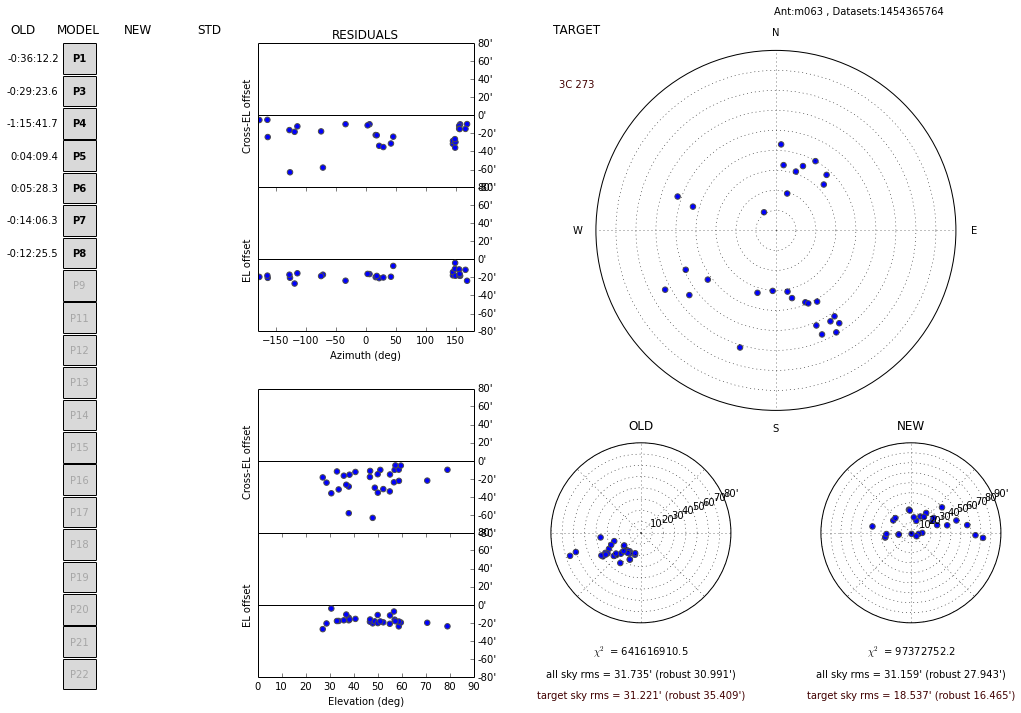

In [8]:
# Basic plot of fitted model
theta_formatter = PolarAxes.ThetaFormatter()
def angle_formatter(x, pos=None):
    return theta_formatter(wrap_angle(np.pi / 2.0 - x), pos)
def arcmin_formatter(x, pos=None):
    return "%g'" % x

# Axis limit to be applied to all residual plots
resid_lim = 1.2 * old.abs_sky_error.max()

def plot_data_and_tooltip(ax, xdata, ydata):
    """Plot data markers and add tooltip to axes (single place to configure them)."""
    ax.dots = ax.scatter(xdata, ydata, 30, 'b', edgecolors='0.3')
    ax.loupe = ax.plot(0, 0, 'o', ms=14, mfc='None', mew=3., visible=False)[0]
    ax.ann = ax.annotate('', xy=(0., 0.), xycoords='data', xytext=(32, 32), textcoords='offset points', size=14,
                         va='bottom', ha='center', bbox=dict(boxstyle='round4', fc='w'), visible=False, zorder=5,
                         arrowprops=dict(arrowstyle='-|>', shrinkB=10, connectionstyle='arc3,rad=-0.2',
                                         fc='w', zorder=4))
def quiver_segments(delta_az, delta_el, scale):
    """Produce line segments that indicate size and direction of residuals."""
    theta1, r1 = np.pi / 2. - az, np.pi / 2. - el
    # Create line segments in Cartesian coords so that they do not change direction when *scale* changes
    x1, y1 = r1 * np.cos(theta1), r1 * np.sin(theta1)
    dx = delta_az * np.cos(el) * np.cos(az) - delta_el * np.sin(az)
    dy = -delta_az * np.cos(el) * np.sin(az) - delta_el * np.cos(az)
    x2, y2 = x1 + scale * dx, y1 + scale * dy
    theta2, r2 = np.arctan2(y2, x2), np.sqrt(x2 ** 2 + y2 ** 2)
    return np.c_[np.c_[theta1, r1], np.c_[theta2, r2]].reshape(-1, 2, 2)

def param_to_str(model, p):
    """Represent value of *p*'th parameter of *model* as a string."""
    parameter = [param for param in model][p]
    # Represent P9 and P12 (scale parameters) in shorter form
    return parameter.value_str if p not in [8, 11] else ("%.3e" % parameter.value)

# Set up figure with buttons
fig = plt.figure(1, figsize=(15, 10))
fig.clear()

# Store highlighted target index on figure object
fig.highlighted_target = 0 # THIS IS WHERE YOU WILL LOOP OVER TARGETS


# Axes to contain detail residual plots - initialise plots with old residuals
ax = fig.add_axes([0.27, 0.74, 0.2, 0.2])
ax.axhline(0, color='k', zorder=0)
plot_data_and_tooltip(ax, rad2deg(az), rad2deg(old.residual_xel) * 60.)
ax.axis([-180., 180., -resid_lim, resid_lim])
ax.set_xticks([])
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
ax.set_ylabel('Cross-EL offset')
ax.set_title('RESIDUALS')

ax = fig.add_axes([0.27, 0.54, 0.2, 0.2])
ax.axhline(0, color='k', zorder=0)
plot_data_and_tooltip(ax, rad2deg(az), rad2deg(old.residual_el) * 60.)
ax.axis([-180., 180., -resid_lim, resid_lim])
ax.set_xlabel('Azimuth (deg)')
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
ax.set_ylabel('EL offset')

ax = fig.add_axes([0.27, 0.26, 0.2, 0.2])
ax.axhline(0, color='k', zorder=0)
plot_data_and_tooltip(ax, rad2deg(el), rad2deg(old.residual_xel) * 60.)
ax.axis([0., 90., -resid_lim, resid_lim])
ax.set_xticks([])
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
ax.set_ylabel('Cross-EL offset')

ax = fig.add_axes([0.27, 0.06, 0.2, 0.2])
ax.axhline(0, color='k', zorder=0)
plot_data_and_tooltip(ax, rad2deg(el), rad2deg(old.residual_el) * 60.)
ax.axis([0., 90., -resid_lim, resid_lim])
ax.set_xlabel('Elevation (deg)')
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
ax.set_ylabel('EL offset')

# Axes to contain quiver plot - plot static measurement locations in ARC projection as a start
ax = fig.add_axes([0.5, 0.43, 0.5, 0.5], projection='polar')
plot_data_and_tooltip(ax, np.pi/2. - az, np.pi/2. - el)
segms = quiver_segments(old.residual_az, old.residual_el, 0.)
ax.quiv = mpl.collections.LineCollection(segms, color='0.3')
ax.add_collection(ax.quiv)
ax.set_xticks(deg2rad(np.arange(0., 360., 90.)))
ax.set_xticklabels(['E', 'N', 'W', 'S'])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(angle_formatter))
ax.set_ylim(0., np.pi / 2.)
ax.set_yticks(deg2rad(np.arange(0., 90., 10.)))
ax.set_yticklabels([])

# Axes to contain before/after residual plot
ax = fig.add_axes([0.5, 0.135, 0.25, 0.25], projection='polar')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
plot_data_and_tooltip(ax, np.arctan2(old.residual_el, old.residual_xel), old.abs_sky_error)
ax.set_xticklabels([])
ax.set_title('OLD')
fig.text(0.625, 0.09, "$\chi^2$ = %.1f" % (old.chi2,), ha='center', va='baseline')
fig.text(0.625, 0.06, "all sky rms = %.3f' (robust %.3f')" % (old.sky_rms, old.robust_sky_rms),
         ha='center', va='baseline')
old.metrics(target_index == fig.highlighted_target)
fig.text(0.625, 0.03, "target sky rms = %.3f' (robust %.3f')" % (old.sky_rms, old.robust_sky_rms),
         ha='center', va='baseline', fontdict=dict(color=(0.25,0,0,1)))
old.metrics(keep)

ax = fig.add_axes([0.75, 0.135, 0.25, 0.25], projection='polar')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
plot_data_and_tooltip(ax, np.arctan2(new.residual_el, new.residual_xel), new.abs_sky_error)
ax.set_xticklabels([])
ax.set_title('NEW')
fig.text(0.875, 0.09, "$\chi^2$ = %.1f" % (new.chi2,), ha='center', va='baseline')
fig.text(0.875, 0.06, "all sky rms = %.3f' (robust %.3f')" % (new.sky_rms, new.robust_sky_rms),
         ha='center', va='baseline')
new.metrics(target_index == fig.highlighted_target)
fig.text(0.875, 0.03, "target sky rms = %.3f' (robust %.3f')" % (new.sky_rms, new.robust_sky_rms),
         ha='center', va='baseline', fontdict=dict(color=(0.25,0,0,1)))
new.metrics(keep)

param_button_color = ['0.65', '0.0']
param_button_weight = ['normal', 'bold']
# For display purposes, throw out unused parameters P2 and P10
display_params = range(num_params)
display_params.pop(9)
display_params.pop(1)
def setup_param_button(p):
    """Set up individual parameter toggle button."""
    param = display_params[p]
    param_button = mpl.widgets.Button(fig.add_axes([0.09, 0.94 - (0.85 + p * 0.9) / len(display_params),
                                                    0.03, 0.85 / len(display_params)]), 'P%d' % (param + 1,))
    fig.text(0.19, 0.94 - (0.5 * 0.85 + p * 0.9) / len(display_params), '', ha='right', va='center')
    fig.text(0.24, 0.94 - (0.5 * 0.85 + p * 0.9) / len(display_params), '', ha='right', va='center')
    state = enabled_params[param]
    param_button.label.set_color(param_button_color[state])
    param_button.label.set_weight(param_button_weight[state])
    def toggle_param_callback(event):
        state = not enabled_params[param]
        enabled_params[param] = state
        param_button.label.set_color(param_button_color[state])
        param_button.label.set_weight(param_button_weight[state])
        save_button.color = (0.85, 0, 0)
        save_button.hovercolor = (0.95, 0, 0)
        update(fig)
    param_button.on_clicked(toggle_param_callback)
    return param_button # This is to stop the gc from deleting the data
param_buttons = [setup_param_button(p) for p in xrange(len(display_params))]

# Add old pointing model and labels
list_o_names = 'Ant:%s , Datasets:'%(antenna.name) + ' ,'.join(np.unique(data['dataset']).tolist() )
fig.text(0.905, 0.98,list_o_names, horizontalalignment='right',fontsize=10)
fig.text(0.053, 0.95, 'OLD', ha='center', va='bottom', size='large')
fig.text(0.105, 0.95, 'MODEL', ha='center', va='bottom', size='large')
fig.text(0.16, 0.95, 'NEW', ha='center', va='bottom', size='large')
fig.text(0.225, 0.95, 'STD', ha='center', va='bottom', size='large')
for p, param in enumerate(display_params):
    param_str = param_to_str(old_model, param) if old_model.values()[param] else ''
    fig.text(0.085, 0.94 - (0.5 * 0.85 + p * 0.9) / len(display_params), param_str, ha='right', va='center')
    
# Create target selector buttons and related text (title + target string)
fig.text(0.565, 0.95, 'TARGET', ha='center', va='bottom', size='large')
fig.text(0.565, 0.89, unique_targets[fig.highlighted_target], ha='center', va='top', fontdict=dict(color=(0.25,0,0,1)))

# Output and Report

In [9]:
now = time.strftime('%Y-%m-%d_%Hh%M')
outfilebase='pointing_model_%s' % (now,)
# Save pointing model to file
outfile = file(outfilebase + '.csv', 'w')
# The original pointing model description string was comma-separated
outfile.write(new_model.description.replace(" ", ", "))
outfile.close()
print("Saved %d-parameter pointing model to '%s'" % (len(new_model), outfilebase + '.csv'))
# Turn data recarray into list of dicts and add residuals to the mix
extended_data = []
for n in range(len(data)):
    rec_dict = dict(zip(data.dtype.names, data[n]))
    rec_dict['keep'] = int(keep[n])
    rec_dict['old_residual_xel'] = rad2deg(old.residual_xel[n])
    rec_dict['old_residual_el'] = rad2deg(old.residual_el[n])
    rec_dict['new_residual_xel'] = rad2deg(new.residual_xel[n])
    rec_dict['new_residual_el'] = rad2deg(new.residual_el[n])
    extended_data.append(rec_dict)
# Format the data similar to analyse_point_source_scans output CSV file, with four new columns at the end
fields = '%(dataset)s, %(target)s, %(timestamp_ut)s, %(azimuth).7f, %(elevation).7f, ' \
         '%(delta_azimuth).7f, %(delta_azimuth_std).7f, %(delta_elevation).7f, %(delta_elevation_std).7f, ' \
         '%(data_unit)s, %(beam_height_I).7f, %(beam_height_I_std).7f, %(beam_width_I).7f, ' \
        '%(beam_width_I_std).7f, %(baseline_height_I).7f, %(baseline_height_I_std).7f, %(refined_I).0f, ' \
         '%(beam_height_HH).7f, %(beam_width_HH).7f, %(baseline_height_HH).7f, %(refined_HH).0f, ' \
         '%(beam_height_VV).7f, %(beam_width_VV).7f, %(baseline_height_VV).7f, %(refined_VV).0f, ' \
         '%(frequency).7f, %(flux).4f, %(temperature).2f, %(pressure).2f, %(humidity).2f, %(wind_speed).2f, ' \
         '%(keep)d, %(old_residual_xel).7f, %(old_residual_el).7f, %(new_residual_xel).7f, %(new_residual_el).7f\n'
field_names = [name.partition(')')[0] for name in fields[2:].split(', %(')]
# Save residual data and flags to file
outfile2 = file(outfilebase + '_data.csv', 'w')
outfile2.write('# antenna = %s\n' % antenna.description)
outfile2.write(', '.join(field_names) + '\n')
outfile2.writelines([fields % rec for rec in extended_data])
outfile2.close()

Saved 22-parameter pointing model to 'pointing_model_2016-02-10_17h37.csv'


In [19]:
nice_filename =  os.path.splitext(os.path.basename(filename))[0]+ '_pointing_model'
pp = PdfPages(nice_filename+'.pdf')

pagetext = []
i = 0
tmpstr = ""
linelength = 5
pagetext.append("List of targets used:")
for tar in list(set(unique_targets)):
    if  i % linelength == linelength-1 :
        pagetext.append(tmpstr)
        tmpstr = ""
    i = i + 1
    tmpstr +='%s, '%(tar)
pagetext.append(tmpstr)
pagetext.append("Pointing metrics for fitted points. (N= %i  Fitting Data Points) "%(np.sum(keep)))
pagetext.append("New Pointing model:")
pagetext.append(new_model.description.replace(" ", ", "))
pagetext.append("All sky RMS = %.3f' (robust %.3f') " % (new.sky_rms, new.robust_sky_rms))
fig = plt.figure(None,figsize = (10,16))
plt.figtext(0.1,0.1,'\n'.join(pagetext),fontsize=12)
fig.savefig(pp,format='pdf')
plt.close(fig)


# List of colors used to represent different targets in scatter plots
scatter_colors = ('b', 'r', 'g', 'k', 'c', 'm', 'y')
target_colors = np.tile(scatter_colors, 1 + len(unique_targets) // len(scatter_colors))[:len(unique_targets)]
# Quantity loosely related to the declination of the source
north = (np.pi / 2. - el) / (np.pi / 2.) * np.cos(az)
pseudo_dec = -np.ones(len(unique_targets))
for n, ind in enumerate(target_index):
    if north[n] > pseudo_dec[ind]:
        pseudo_dec[ind] = north[n]
north_to_south = np.flipud(np.argsort(pseudo_dec))
target_colors = target_colors[north_to_south][target_index]

for idx in np.unique(target_index):
    fig = plt.figure(1, figsize=(15, 10))
    fig.clear()

    # Store highlighted target index on figure object
    fig.highlighted_target = idx
    print idx, unique_targets[fig.highlighted_target]

    # Axes to contain detail residual plots - initialise plots with old residuals
    ax = fig.add_axes([0.27, 0.74, 0.2, 0.2])
    ax.axhline(0, color='k', zorder=0)
    plot_data_and_tooltip(ax, rad2deg(az), rad2deg(old.residual_xel) * 60.)
    ax.axis([-180., 180., -resid_lim, resid_lim])
    ax.set_xticks([])
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
    ax.set_ylabel('Cross-EL offset')
    ax.set_title('RESIDUALS')

    ax = fig.add_axes([0.27, 0.54, 0.2, 0.2])
    ax.axhline(0, color='k', zorder=0)
    plot_data_and_tooltip(ax, rad2deg(az), rad2deg(old.residual_el) * 60.)
    ax.axis([-180., 180., -resid_lim, resid_lim])
    ax.set_xlabel('Azimuth (deg)')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
    ax.set_ylabel('EL offset')

    ax = fig.add_axes([0.27, 0.26, 0.2, 0.2])
    ax.axhline(0, color='k', zorder=0)
    plot_data_and_tooltip(ax, rad2deg(el), rad2deg(old.residual_xel) * 60.)
    ax.axis([0., 90., -resid_lim, resid_lim])
    ax.set_xticks([])
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
    ax.set_ylabel('Cross-EL offset')

    ax = fig.add_axes([0.27, 0.06, 0.2, 0.2])
    ax.axhline(0, color='k', zorder=0)
    plot_data_and_tooltip(ax, rad2deg(el), rad2deg(old.residual_el) * 60.)
    ax.axis([0., 90., -resid_lim, resid_lim])
    ax.set_xlabel('Elevation (deg)')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
    ax.set_ylabel('EL offset')

    # Axes to contain quiver plot - plot static measurement locations in ARC projection as a start
    ax = fig.add_axes([0.5, 0.43, 0.5, 0.5], projection='polar')
    plot_data_and_tooltip(ax, np.pi/2. - az, np.pi/2. - el)
    segms = quiver_segments(old.residual_az, old.residual_el, 0.)
    ax.quiv = mpl.collections.LineCollection(segms, color='0.3')
    ax.add_collection(ax.quiv)
    ax.set_xticks(deg2rad(np.arange(0., 360., 90.)))
    ax.set_xticklabels(['E', 'N', 'W', 'S'])
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(angle_formatter))
    ax.set_ylim(0., np.pi / 2.)
    ax.set_yticks(deg2rad(np.arange(0., 90., 10.)))
    ax.set_yticklabels([])

    # Axes to contain before/after residual plot
    ax = fig.add_axes([0.5, 0.135, 0.25, 0.25], projection='polar')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
    plot_data_and_tooltip(ax, np.arctan2(old.residual_el, old.residual_xel), old.abs_sky_error)
    ax.set_xticklabels([])
    ax.set_title('OLD')
    fig.text(0.625, 0.09, "$\chi^2$ = %.1f" % (old.chi2,), ha='center', va='baseline')
    fig.text(0.625, 0.06, "all sky rms = %.3f' (robust %.3f')" % (old.sky_rms, old.robust_sky_rms),
             ha='center', va='baseline')
    old.metrics(target_index == fig.highlighted_target)
    fig.text(0.625, 0.03, "target sky rms = %.3f' (robust %.3f')" % (old.sky_rms, old.robust_sky_rms),
             ha='center', va='baseline', fontdict=dict(color=(0.25,0,0,1)))
    old.metrics(keep)

    ax = fig.add_axes([0.75, 0.135, 0.25, 0.25], projection='polar')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(arcmin_formatter))
    plot_data_and_tooltip(ax, np.arctan2(new.residual_el, new.residual_xel), new.abs_sky_error)
    ax.set_xticklabels([])
    ax.set_title('NEW')
    fig.text(0.875, 0.09, "$\chi^2$ = %.1f" % (new.chi2,), ha='center', va='baseline')
    fig.text(0.875, 0.06, "all sky rms = %.3f' (robust %.3f')" % (new.sky_rms, new.robust_sky_rms),
             ha='center', va='baseline')
    new.metrics(target_index == fig.highlighted_target)
    fig.text(0.875, 0.03, "target sky rms = %.3f' (robust %.3f')" % (new.sky_rms, new.robust_sky_rms),
             ha='center', va='baseline', fontdict=dict(color=(0.25,0,0,1)))
    new.metrics(keep)

    param_button_color = ['0.65', '0.0']
    param_button_weight = ['normal', 'bold']
    # For display purposes, throw out unused parameters P2 and P10
    display_params = range(num_params)
    display_params.pop(9)
    display_params.pop(1)
    def setup_param_button(p):
        """Set up individual parameter toggle button."""
        param = display_params[p]
        param_button = mpl.widgets.Button(fig.add_axes([0.09, 0.94 - (0.85 + p * 0.9) / len(display_params),
                                                        0.03, 0.85 / len(display_params)]), 'P%d' % (param + 1,))
        fig.text(0.19, 0.94 - (0.5 * 0.85 + p * 0.9) / len(display_params), '', ha='right', va='center')
        fig.text(0.24, 0.94 - (0.5 * 0.85 + p * 0.9) / len(display_params), '', ha='right', va='center')
        state = enabled_params[param]
        param_button.label.set_color(param_button_color[state])
        param_button.label.set_weight(param_button_weight[state])
        def toggle_param_callback(event):
            state = not enabled_params[param]
            enabled_params[param] = state
            param_button.label.set_color(param_button_color[state])
            param_button.label.set_weight(param_button_weight[state])
            save_button.color = (0.85, 0, 0)
            save_button.hovercolor = (0.95, 0, 0)
            update(fig)
        param_button.on_clicked(toggle_param_callback)
        return param_button # This is to stop the gc from deleting the data
    param_buttons = [setup_param_button(p) for p in xrange(len(display_params))]

    # Add old pointing model and labels
    list_o_names = 'Ant:%s , Datasets:'%(antenna.name) + ' ,'.join(np.unique(data['dataset']).tolist() )
    fig.text(0.905, 0.98,list_o_names, horizontalalignment='right',fontsize=10)
    fig.text(0.053, 0.95, 'OLD', ha='center', va='bottom', size='large')
    fig.text(0.105, 0.95, 'MODEL', ha='center', va='bottom', size='large')
    fig.text(0.16, 0.95, 'NEW', ha='center', va='bottom', size='large')
    fig.text(0.225, 0.95, 'STD', ha='center', va='bottom', size='large')
    for p, param in enumerate(display_params):
        param_str = param_to_str(old_model, param) if old_model.values()[param] else ''
        fig.text(0.085, 0.94 - (0.5 * 0.85 + p * 0.9) / len(display_params), param_str, ha='right', va='center')

    # Create target selector buttons and related text (title + target string)
    fig.text(0.565, 0.95, 'TARGET', ha='center', va='bottom', size='large')
    fig.text(0.565, 0.89, unique_targets[fig.highlighted_target], ha='center', va='top', fontdict=dict(color=(0.25,0,0,1)))

    # Target state: 0 = flagged, 1 = unflagged, 2 = highlighted
    target_state = keep * ((target_index == fig.highlighted_target) + 1)
    # Specify colours of flagged, unflagged and highlighted dots, respectively, as RGBA tuples
    dot_colors = np.choose(target_state, np.atleast_3d(np.vstack([(1,1,1,1), (0,0,1,1), (1,0,0,1)]))).T
    for ax in fig.axes[:7]:
        ax.dots.set_facecolors(dot_colors)

    fig.texts[-1].set_text(unique_targets[fig.highlighted_target])
    for p, param in enumerate(display_params):
        fig.texts[2*p + 6].set_text(param_to_str(new_model, param) if enabled_params[param] else '')
        # HACK to convert sigmas to arcminutes, but not for P9 and P12 (which are scale factors)
        # This functionality should really reside inside the PointingModel class
        std_param = rad2deg(sigma_params[param]) * 60. if param not in [8, 11] else sigma_params[param]
        std_param_str = ("%.2f'" % std_param) if param not in [8, 11] else ("%.0e" % std_param)
        fig.texts[2*p + 7].set_text(std_param_str if enabled_params[param] and use_stats else '')
        # Turn parameter string bold if it changed significantly from old value
        if np.abs(params[param] - old_model.values()[param]) > 3.0 * sigma_params[param]:
            fig.texts[2*p + 6].set_weight('bold')
            fig.texts[2*p + 7].set_weight('bold')
        else:
            fig.texts[2*p + 6].set_weight('normal')
            fig.texts[2*p + 7].set_weight('normal')
    daz_az, del_az, daz_el, del_el, quiver, before, after = fig.axes[:7]
    # Update residual plots
    daz_az.dots.set_offsets(np.c_[rad2deg(az), rad2deg(new.residual_xel) * 60.])
    del_az.dots.set_offsets(np.c_[rad2deg(az), rad2deg(new.residual_el) * 60.])
    daz_el.dots.set_offsets(np.c_[rad2deg(el), rad2deg(new.residual_xel) * 60.])
    del_el.dots.set_offsets(np.c_[rad2deg(el), rad2deg(new.residual_el) * 60.])
    after.dots.set_offsets(np.c_[np.arctan2(new.residual_el, new.residual_xel), new.abs_sky_error])
    resid_lim = 1.2 * max(new.abs_sky_error.max(), old.abs_sky_error.max())
    daz_az.set_ylim(-resid_lim, resid_lim)
    del_az.set_ylim(-resid_lim, resid_lim)
    daz_el.set_ylim(-resid_lim, resid_lim)
    del_el.set_ylim(-resid_lim, resid_lim)
    before.set_ylim(0, resid_lim)
    after.set_ylim(0, resid_lim)
    
    fig.savefig(pp,format='pdf')
    plt.close(fig)

pp.close()

0 3C 273
1 3C 279
2 3C 353
3 3C 358
4 Her A
5 Hyd A
6 Ori A
7 PKS 0410-75
8 PKS 0521-36
9 PKS 1610-60
10 PKS 1814-63
11 PKS 1934-63
12 PKS 2153-69
13 Pic A
14 Vir A
